# Prostate Cancer Worshop

## Initial analysis

### Imports

In [113]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import skew, kurtosis
from IPython.display import display

from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from feature_engine.outliers import Winsorizer
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from bayes_opt import BayesianOptimization

import lightgbm as lgb
from xgboost import XGBClassifier


### LoadingData

In [9]:
df_train = pq.read_table('data/df_train.parquet').to_pandas()
df_test = pq.read_table('data/df_test.parquet').to_pandas()

df_train.shape

(23494, 46)

In [10]:
df_train.head()

,MEDICAMENTOS,MEDICINA ESPECIALIZADA,MEDICINA GENERAL,Cant_gr_flia,Cant_riesgos_flia_mean,min_Tiempo_CP_Fliar,Cant_Fliar_CP,psa_max_gr_flia,psa_min_gr_flia,Cant_Fliar_riesgos,...,CORONARIOS_FAMILIAR,CEREBRAL,CEREBRAL_FAMILIAR,ENFERMEDAD_RENAL,ENFERMEDAD_RENAL_FAMILIAR,OTROS_ANTECEDENTES_VASCULARES,Target,Pendiente,Intercepto,Promedio_costo
ID,,,,,,,,,,,,,,,,,,,,,
16484,12.0,3.0,3.0,2,0.0,NaN,0.0,NaN,NaN,0.0,...,0,0,0,0,0,0,0,58373.057143,-110021.200000,1.885690e+05
11528,6.0,1.0,1.0,2,0.5,NaN,0.0,NaN,NaN,1.0,...,0,0,0,0,0,0,0,19618.942857,-36176.133333,9.747050e+04
26630,1.0,0.0,2.0,2,0.0,NaN,0.0,NaN,NaN,0.0,...,0,0,0,0,0,0,1,398534.000000,-626628.000000,2.304723e+06
12586,6.0,0.0,2.0,2,0.0,NaN,0.0,NaN,NaN,0.0,...,0,0,0,0,0,0,0,1292.600000,13410.733333,5.380450e+04
11225,3.0,0.0,2.0,1,1.0,NaN,0.0,NaN,NaN,1.0,...,2,2,2,2,2,2,0,13728.714286,-27375.666667,4.134967e+04


In [28]:
numeric_columns = [
    'Cant_gr_flia', 
    'Cant_riesgos_flia_mean', 
    'cantidad_serv_flia', 
    'CANTIDAD_SERVICIOS', 
    'conteo_dx_diferentes', 
    'EDAD', 
    'psa_max_gr_flia', 
    'psa_min_gr_flia', 
    'Pendiente', 
    'Pendiente_flia', 
    'Promedio_costo', 
    'Promedio_costo_flia', 
    'psa_max_gr_flia', 
    'psa_min_gr_flia', 
    'MEDICAMENTOS', 
    'MEDICINA ESPECIALIZADA', 
    'MEDICINA GENERAL', 
    'TIEMPO_AFILIACION', 
    'TIEMPO_ULTIMA_CITA', 
    'PERDIDA_DE_PESO', 
    'Intercepto', 
    'Intercepto_flia', 
    'Target', 
    'Cant_Fliar_CP', 
    'Cant_Fliar_riesgos'
]

categorical_columns = [
    'AGRUPACION_DIASTOLICA', 
    'AGRUPACION_SISTOLICA', 
    'CANCER_MAMA_FAMILIAR', 
    'CANCER_OTRO_SITIO', 
    'CORONARIOS', 
    'CANCER_OTRO_SITIO_FAMILIAR',
    'CORONARIOS_FAMILIAR', 
    'CEREBRAL', 
    'CEREBRAL_FAMILIAR', 
    'DIABETES', 
    'DIABETES_FAMILIAR', 
    'ENFERMEDAD_RENAL', 
    'ENFERMEDAD_RENAL_FAMILIAR', 
    'HIPERTENSION', 
    'HIPERTENSION_FAMILIAR', 
    'OTROS_ANTECEDENTES_VASCULARES', 
    'RIESGOS', 
    'ESTADO_CIVI', 
    'estrato', 
    'parentesco', 
    'PROGRAMA', 
]

In [29]:
ordinal_columns = [
    'AGRUPACION_DIASTOLICA',
    'AGRUPACION_SISTOLICA',
    'HIPERTENSION',
    'HIPERTENSION_FAMILIAR',
    'RIESGOS',
    'estrato'
]

nominal_columns = [
    'CANCER_MAMA_FAMILIAR',
    'CANCER_OTRO_SITIO',
    'CORONARIOS',
    'CANCER_OTRO_SITIO_FAMILIAR',
    'CORONARIOS_FAMILIAR',
    'CEREBRAL',
    'CEREBRAL_FAMILIAR',
    'DIABETES',
    'DIABETES_FAMILIAR',
    'ENFERMEDAD_RENAL',
    'ENFERMEDAD_RENAL_FAMILIAR',
    'OTROS_ANTECEDENTES_VASCULARES',
    'ESTADO_CIVI',
    'parentesco',
    'PROGRAMA'                  
]



### Feature Importance

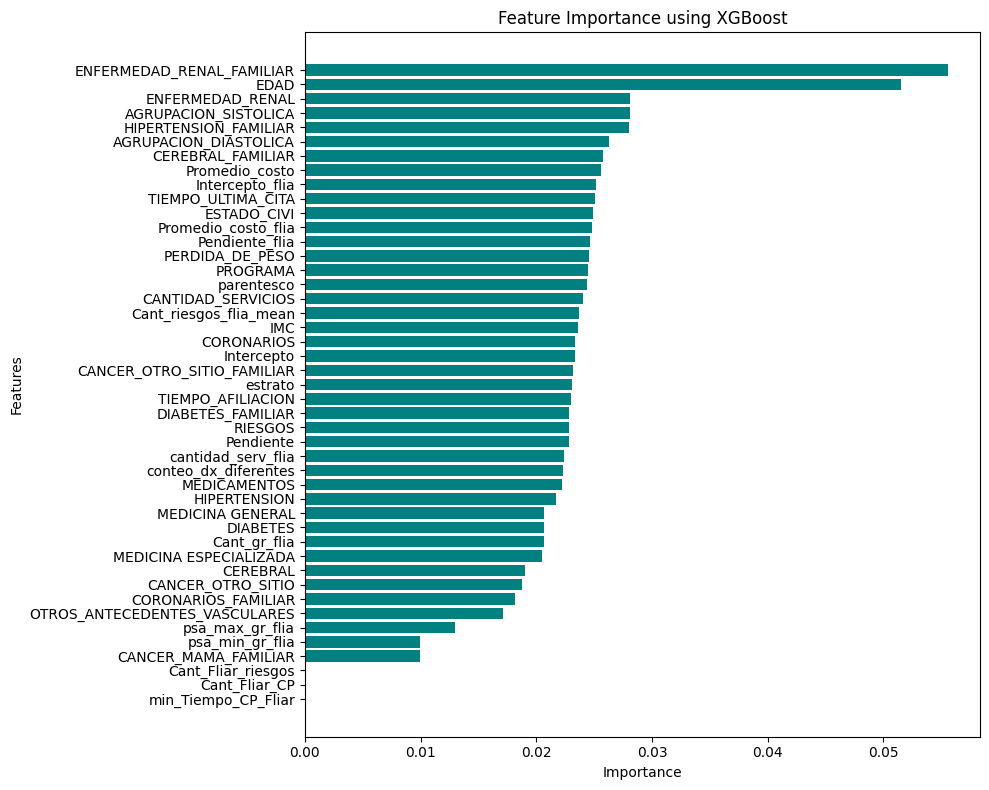

In [12]:
df_encoded = df_train.copy()
for column in ordinal_columns + nominal_columns + ['IMC']:
    df_encoded[column] = df_encoded[column].astype('category')
X = df_encoded.drop(columns=['Target'])
y = df_encoded['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', enable_categorical=True)
model.fit(X_train, y_train)

importances = model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='teal')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance using XGBoost')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [24]:
features_to_drop = ['Cant_Fliar_riesgos', 'Cant_Fliar_CP', 'min_Tiempo_CP_Fliar', 'psa_min_gr_flia', 'psa_max_gr_flia', 'CANCER_MAMA_FAMILIAR']

### Validate dropping features
- In order to be sure whether we decide to drop or not the already identified features, we will run a preliminary model to test with and without the features

In [27]:
def train_and_evaluate(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', enable_categorical=True)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    
    return f1

# Model 1: With all features
X_all_features = df_encoded.drop(columns=['Target'])
y = df_encoded['Target']

f1_all_features = train_and_evaluate(X_all_features, y)
print(f"F1 Score with all features: {f1_all_features}")

# Model 2: Dropping variables with zero importance
X_reduced_features = df_encoded.drop(columns=['Target'] + features_to_drop)

f1_reduced_features = train_and_evaluate(X_reduced_features, y)
print(f"F1 Score after dropping zero-importance features: {f1_reduced_features}")

F1 Score with all features: 0.5206929740134745
F1 Score after dropping zero-importance features: 0.5384252710985383


After dropping additional features, including `'Cant_Fliar_riesgos'`, `'Cant_Fliar_CP'`, `'min_Tiempo_CP_Fliar'`, `'psa_min_gr_flia'`, `'psa_max_gr_flia'`, and `'CANCER_MAMA_FAMILIAR'`, the model's performance improved. The F1 score increased from **0.5207** (with all features) to **0.5384** (after removing these features), indicating that simplifying the model by excluding both zero-importance features and those with minimal predictive power can enhance the model’s performance. By reducing noise from less significant features, the model was able to generalize better and make more accurate predictions, showcasing the benefits of feature selection in machine learning.

## Preprocessing Pipeline_________________________________________________

In [102]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('winsorizer', Winsorizer(capping_method='quantiles', tail='right', fold=0.05)),
])

ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal_encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

nominal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_columns),
        ('ord', ordinal_transformer, ordinal_columns),
        ('nom', nominal_transformer, nominal_columns)
    ]
)

pipeline = Pipeline(steps=[
    ('drop_columns', 'passthrough'),
    ('preprocessor', preprocessor)
])

#### Applying preprocessor pipeline
- Imputation and dropping

In [103]:
X = df_train.drop(columns=features_to_drop)
y = df_train['Target']

pipeline.fit(X)
X_train_transformed = pipeline.transform(X)


#### Converting the pipeline output into a readable data frame

In [104]:
transformed_columns = (
    numeric_columns + 
    ordinal_columns + 
    list(pipeline.named_steps['preprocessor'].transformers_[2][1]['onehot'].get_feature_names_out(nominal_columns))
)

X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=transformed_columns)
X_train_transformed_df

,Cant_gr_flia,Cant_riesgos_flia_mean,cantidad_serv_flia,CANTIDAD_SERVICIOS,conteo_dx_diferentes,EDAD,Pendiente,Pendiente_flia,Promedio_costo,Promedio_costo_flia,...,parentesco_Conyuge,parentesco_Hijo,parentesco_None,parentesco_Otros,parentesco_Padres,parentesco_Sin Descripcion,parentesco_Trabajador,PROGRAMA_PAC,PROGRAMA_POS,PROGRAMA_RS
0,2.0,0.0,34.0,14.0,5.0,55.0,58373.057143,15998.485714,1.885690e+05,48947.25,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2.0,0.5,25.0,9.0,3.0,55.0,19618.942857,655.200000,9.747050e+04,7644.00,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2.0,0.0,36.0,17.0,5.0,59.0,92816.864286,176929.295714,1.054676e+06,1013991.00,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,2.0,0.0,24.0,4.0,3.0,55.0,1292.600000,-4468.285714,5.380450e+04,22572.50,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.0,1.0,7.0,6.0,3.0,53.0,13728.714286,0.000000,4.134967e+04,0.00,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23489,3.0,0.0,22.0,2.0,1.0,55.0,6628.571429,18670.800000,4.640000e+04,99173.00,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
23490,1.0,1.0,11.0,7.0,3.0,49.0,36161.142857,462.857143,9.038500e+04,3240.00,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
23491,1.0,0.0,15.0,11.0,5.0,53.0,15912.885714,5247.171429,1.078278e+05,38615.50,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
23492,1.0,0.0,4.0,2.0,2.0,56.0,2685.571429,40.000000,1.879900e+04,280.00,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


<span style="color:red">Revisar el conteo de valores atipicos !!!!!!!!!!!!!</span>

In [105]:
def calculate_iqr(df, numeric_columns):
    """
    This function takes a dataframe and returns a dataframe that contains 
    the Interquartile Range (IQR) for each numeric column in the dataframe.
    
    Parameters:
    df (pd.DataFrame): Input dataframe
    
    Returns:
    pd.DataFrame: Dataframe containing IQR values for each numeric column
    """
    # Select numeric columns from the dataframe
    df_numeric_columns = df[numeric_columns]
    
    # Calculate Q1 (25th percentile) and Q3 (75th percentile) for each numeric column
    Q1 = df_numeric_columns.quantile(0.25)
    Q3 = df_numeric_columns.quantile(0.75)
    
    # Calculate the Interquartile Range (IQR)
    IQR = Q3 - Q1
    
    # Create a dataframe to store the IQR values
    iqr_df = pd.DataFrame({
        'Column': IQR.index,
        'IQR': IQR.values
    }).sort_values(by='IQR', ascending=False)
    
    return iqr_df


In [106]:
iqr_result = calculate_iqr(df_train, numeric_columns)
iqr_result

,Column,IQR
9,Promedio_costo_flia,236650.583333
8,Promedio_costo,146698.083333
17,Intercepto_flia,104989.850000
16,Intercepto,92525.866667
6,Pendiente,19009.150000
7,Pendiente_flia,16466.421429
13,TIEMPO_AFILIACION,206.000000
2,cantidad_serv_flia,29.000000
3,CANTIDAD_SERVICIOS,9.000000
5,EDAD,6.000000


In [107]:
iqr_result_after = calculate_iqr(X_train_transformed_df, numeric_columns)
print(iqr_result_after)

                    Column            IQR
9      Promedio_costo_flia  236650.583333
8           Promedio_costo  146698.083333
17         Intercepto_flia  104989.850000
16              Intercepto   92525.866667
6                Pendiente   19009.150000
7           Pendiente_flia   16466.421429
13       TIEMPO_AFILIACION     206.000000
2       cantidad_serv_flia      29.000000
3       CANTIDAD_SERVICIOS       9.000000
5                     EDAD       6.000000
10            MEDICAMENTOS       6.000000
4     conteo_dx_diferentes       3.000000
12        MEDICINA GENERAL       2.000000
14      TIEMPO_ULTIMA_CITA       1.000000
0             Cant_gr_flia       1.000000
11  MEDICINA ESPECIALIZADA       1.000000
18                  Target       1.000000
1   Cant_riesgos_flia_mean       0.333333
15         PERDIDA_DE_PESO       0.000000


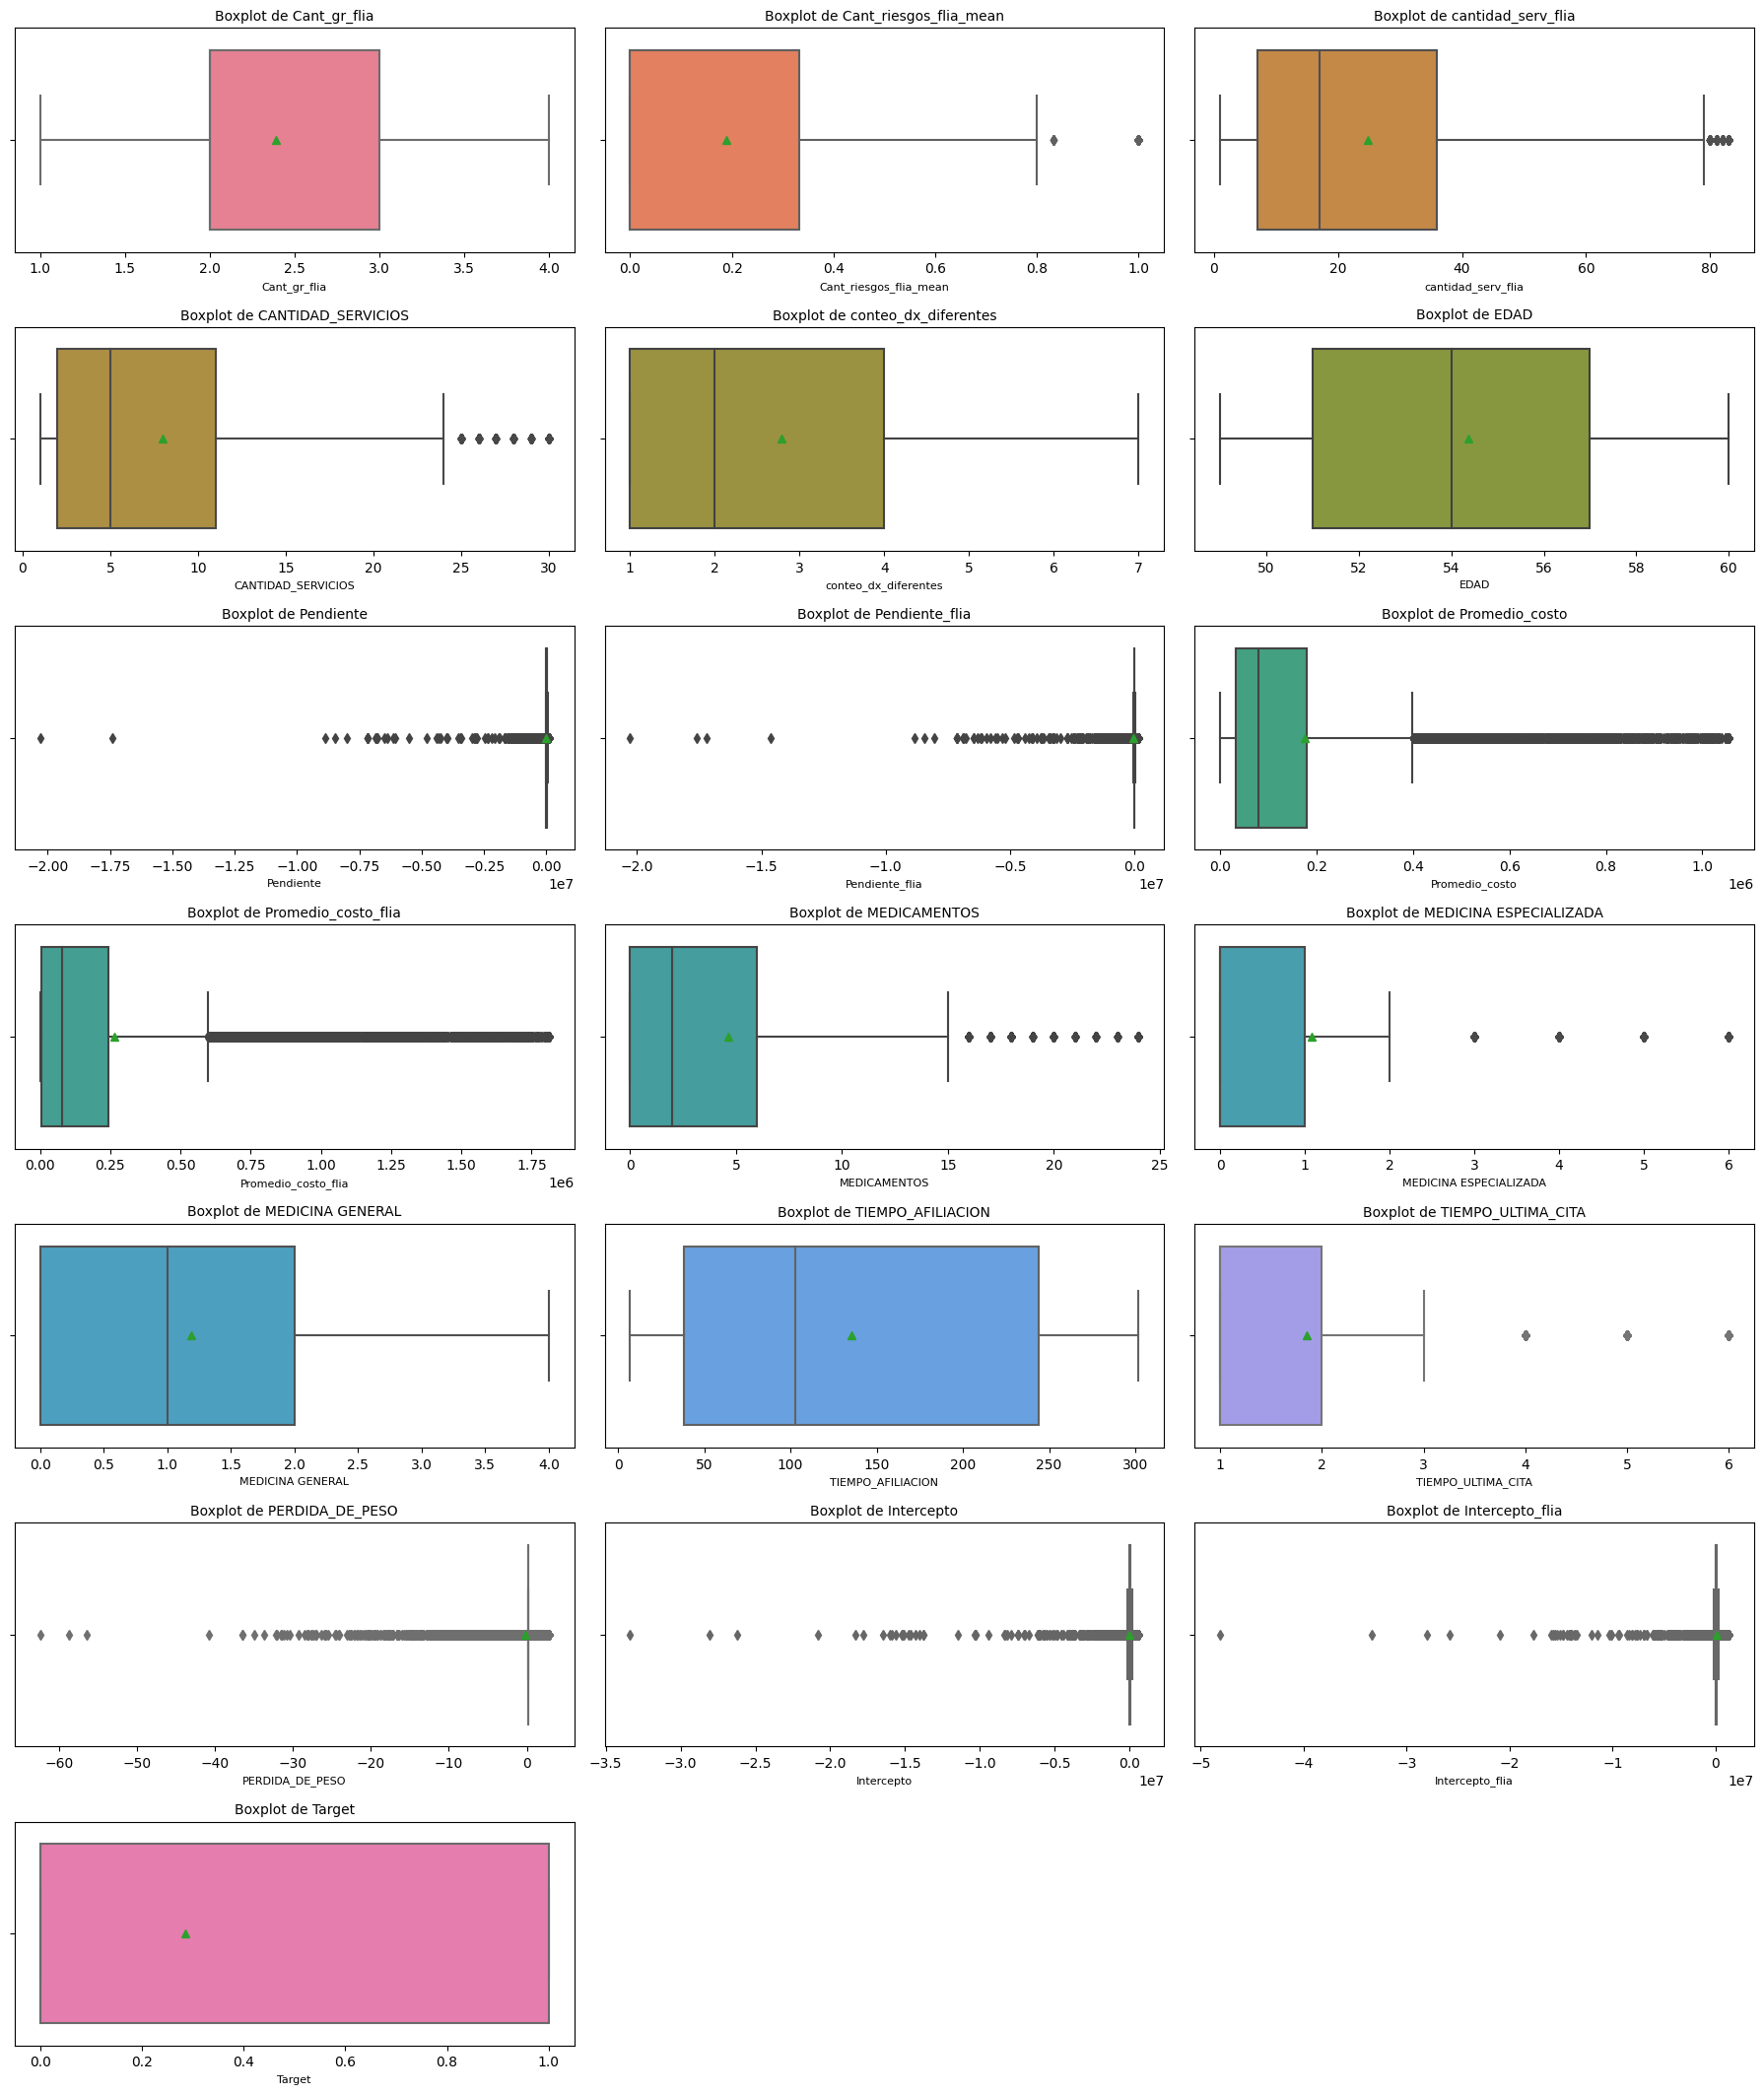

In [112]:
numeric_columns_transformed = X_train_transformed_df[numeric_columns]
columnas_numericas = numeric_columns_transformed.select_dtypes(include=['float64', 'int64']).columns

fig, axes = plt.subplots(nrows=8, ncols=3, figsize=(18, 24))
fig.subplots_adjust(hspace=0.5, wspace=0.4)

colores = sns.color_palette("husl", len(columnas_numericas))

for i, (columna, ax) in enumerate(zip(columnas_numericas, axes.flatten())):
    sns.boxplot(x=numeric_columns_transformed[columna].dropna(), color=colores[i], showmeans=True, ax=ax)
    ax.set_title(f'Boxplot de {columna}', fontsize=10)
    ax.set_xlabel(f'{columna}', fontsize=8)

for j in range(i + 1, len(axes.flatten())):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.show()


### PCA .....

## Bayesian Optimization

In [114]:
def svm_evaluate(C, gamma, kernel_choice):
    """
    Trains and evaluates the SVM with specific hyperparameters and preprocessing.
    """
    kernel = 'linear' if kernel_choice < 0.5 else 'rbf'
    
    # Create a complete pipeline: preprocessing + SVM
    model_pipeline = Pipeline([
        ('preprocessor', preprocessor),  # Include the preprocessing pipeline
        ('svm', SVC(C=C, gamma=gamma, kernel=kernel, probability=True))
    ])
    
    # Perform cross-validation and return mean F1 score
    f1_scores = cross_val_score(model_pipeline, X_train, y_train, cv=5, scoring='f1')
    return f1_scores.mean()

# Define the parameter bounds for Bayesian Optimization
pbounds = {
    'C': (0.1, 10),       # Regularization parameter
    'gamma': (0.0001, 1),  # Kernel coefficient for 'rbf'
    'kernel_choice': (0, 1)  # 0 for 'linear', 1 for 'rbf'
}

# Set up the Bayesian optimizer
optimizer = BayesianOptimization(
    f=svm_evaluate,
    pbounds=pbounds,
    random_state=42,
    verbose=2
)

# Run the optimization
optimizer.maximize(init_points=2, n_iter=10)

# Output the best parameters
best_params = optimizer.max
print("Best parameters found:", best_params)

# Train the final SVM model with the best parameters
C_opt = best_params['params']['C']
gamma_opt = best_params['params']['gamma']
kernel_opt = 'linear' if best_params['params']['kernel_choice'] < 0.5 else 'rbf'

# Final pipeline with best hyperparameters
best_svm_model = Pipeline([
    ('preprocessor', preprocessor),  # Include the preprocessing pipeline
    ('svm', SVC(C=C_opt, gamma=gamma_opt, kernel=kernel_opt, probability=True))
])

# Fit the final model
best_svm_model.fit(X_train, y_train)

# Evaluate the final model on the test set
y_pred = best_svm_model.predict(X_test)
test_f1 = f1_score(y_test, y_pred)
print(f"Final F1 Score on the test set: {test_f1}")

|   iter    |  target   |     C     |   gamma   | kernel... |
-------------------------------------------------------------


KeyboardInterrupt: 